# Paper method 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage import color, filters
import pandas as pd
from skimage.metrics import structural_similarity as ssim
image = cv2.imread("images/test3.png").astype(np.float32) / 255.0
gt = cv2.imread("images/gt3.png").astype(np.float32) / 255.0

## Contrast stretching

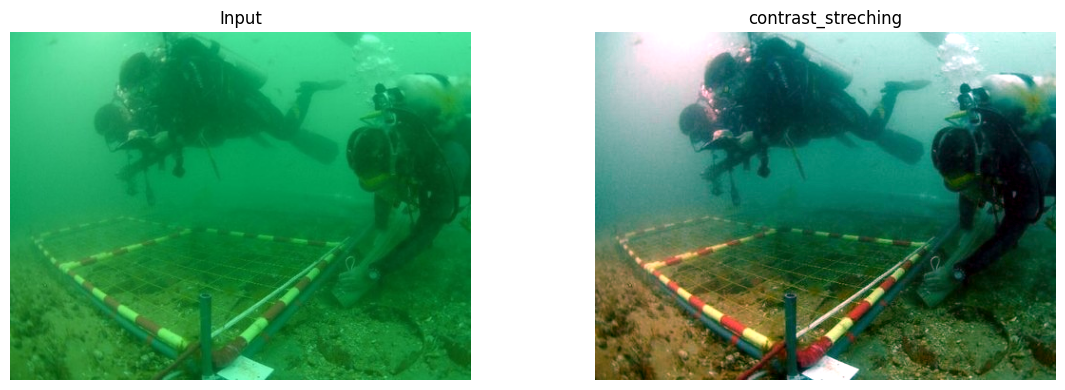

In [2]:
def contrast_streching(image, K=0.005):
    means = image.reshape(-1,3).mean(axis=0)
    maxes = image.reshape(-1,3).max(axis=0)
    ratio = K * (maxes / np.maximum(means, 1e-6))  # three-element vector

    y = np.empty_like(image)
    for c in range(3):
        lowP  = float(np.clip(100.0 * ratio[c], 0, 49.9))
        highP = float(np.clip(100.0 * (1.0 - ratio[c]), 50.1, 100))
        lo, hi = np.percentile(image[..., c], (lowP, highP))
        y[..., c] = np.clip((image[..., c] - lo) / max(hi - lo, 1e-6), 0, 1)
    return y

contrast_streching_image = contrast_streching(image)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));        ax[0].set_title('Input'); ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(contrast_streching_image, cv2.COLOR_BGR2RGB)); ax[1].set_title('contrast_streching'); ax[1].axis('off')
plt.tight_layout(); 
plt.show()

## Equalized Luminance

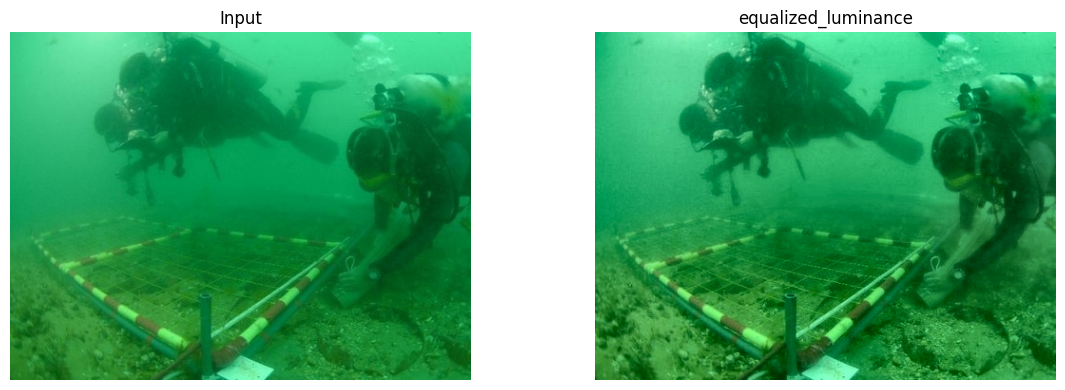

In [3]:
def equalized_luminance(image, clip=1.2, tiles=(8,8)):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L = lab[..., 0]

    L8 = np.clip(L * (255.0/100.0), 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tiles)
    L8_eq = clahe.apply(L8)
    lab[..., 0] = L8_eq.astype(np.float32) * (100.0/255.0)

    out = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return np.clip(out, 0, 1)

lab_eq = equalized_luminance(image)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));        ax[0].set_title('Input'); ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(lab_eq, cv2.COLOR_BGR2RGB)); ax[1].set_title('equalized_luminance'); ax[1].axis('off')
plt.tight_layout(); 
plt.show()

## Weight of multiscale fusion

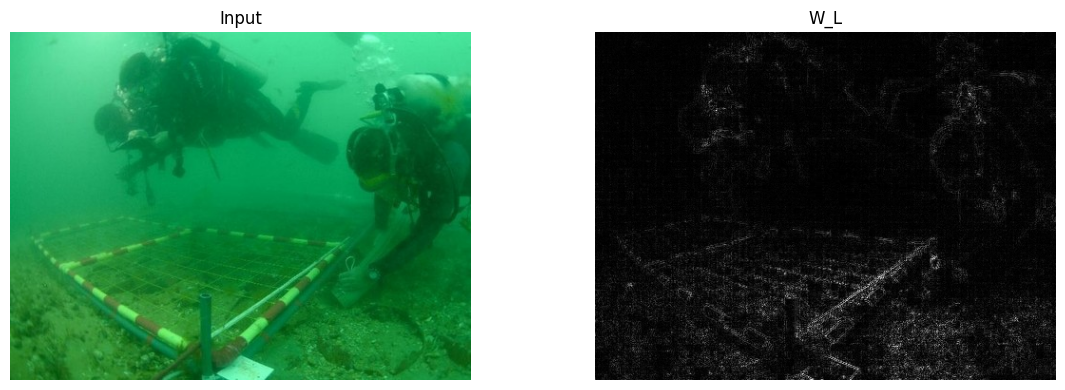

In [4]:
def getW_L(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, _, _ = cv2.split(lab)        
    laplacian = cv2.Laplacian(L, cv2.CV_32F)
    W_L = np.abs(laplacian)
    return W_L

W_L = getW_L(image)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));        ax[0].set_title('Input'); ax[0].axis('off')
ax[1].imshow(W_L, cmap='gray'); ax[1].set_title('W_L'); ax[1].axis('off')
plt.tight_layout(); 
plt.show()
       

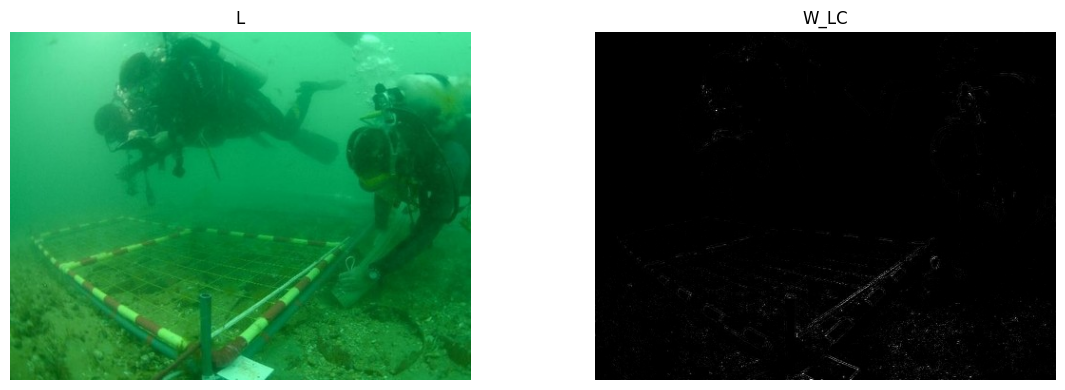

In [5]:
def getW_LC(image, filter=np.array([1, 4, 6, 4, 1], np.float32) / 16.0):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, _, _ = cv2.split(lab)
    avg = cv2.sepFilter2D(L, cv2.CV_32F, filter, filter, borderType=cv2.BORDER_REFLECT101)
    W_LC = (L - avg) ** 2
    return W_LC

W_LC = getW_LC(image)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));      ax[0].set_title('L');         ax[0].axis('off')
ax[1].imshow(W_LC, cmap='gray'); ax[1].set_title('W_LC');    ax[1].axis('off')
plt.tight_layout(); plt.show()

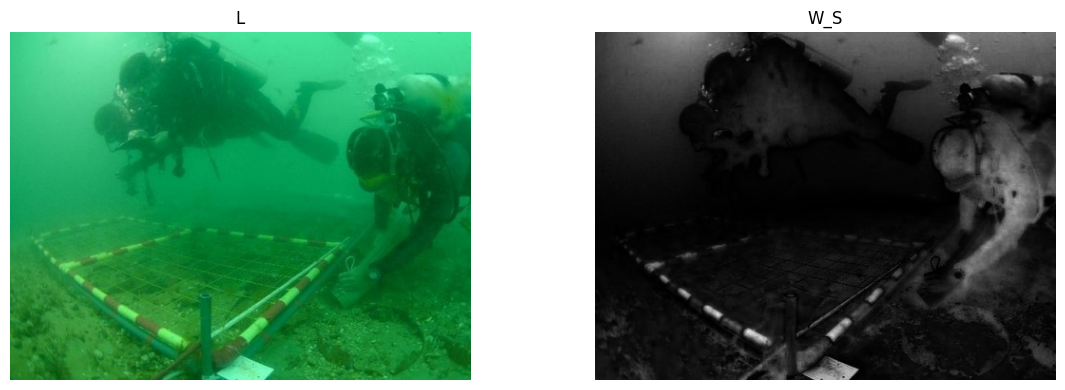

In [6]:
def getW_S(image):
    # input image in BGR channel, default read using cv2
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    lm, am, bm = L.mean(), a.mean(), b.mean()
    W_S = (L - lm)**2 + (a - am)**2 + (b - bm)**2
    return W_S

W_S = getW_S(image)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));      ax[0].set_title('L');         ax[0].axis('off')
ax[1].imshow(W_S, cmap='gray'); ax[1].set_title('W_S');    ax[1].axis('off')
plt.tight_layout(); plt.show()

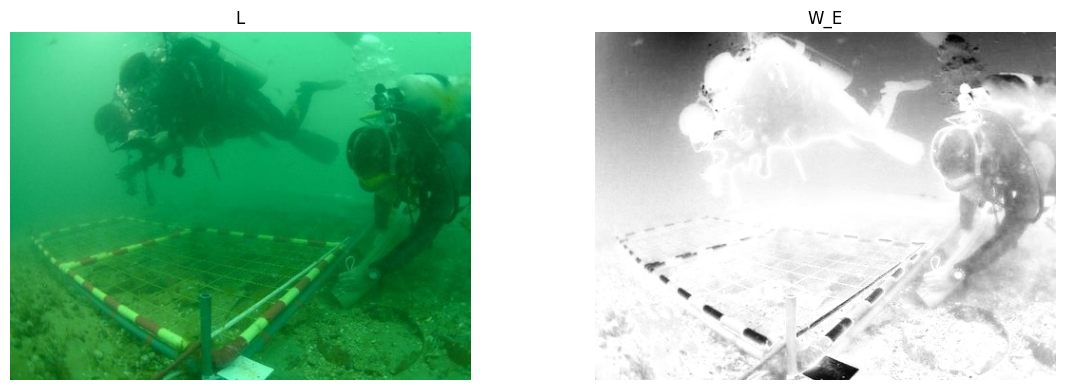

In [7]:
def getW_E(image):
    L = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)[..., 0] / 100
    W_E = np.exp(-(L - 0.5) ** 2 / (2 * 0.25 ** 2))
    return W_E

W_E = getW_E(image)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));      ax[0].set_title('L');         ax[0].axis('off')
ax[1].imshow(W_E, cmap='gray'); ax[1].set_title('W_E');    ax[1].axis('off')
plt.tight_layout(); plt.show()

In [8]:
def getFusionWeight(image1, image2):
    W_L1 = getW_L(image1)
    W_LC1 = getW_LC(image1)
    W_S1 = getW_S(image1)
    W_E1 = getW_E(image1)
    W_L2 = getW_L(image2)
    W_LC2 = getW_LC(image2)
    W_S2 = getW_S(image2)
    W_E2 = getW_E(image2)
    W_1 = (W_L1 + W_LC1 + W_S1 + W_E1) / (W_L1 + W_LC1 + W_S1 + W_E1 + W_L2 + W_LC2 + W_S2 + W_E2)
    W_2 = (W_L2 + W_LC2 + W_S2 + W_E2) / (W_L1 + W_LC1 + W_S1 + W_E1 + W_L2 + W_LC2 + W_S2 + W_E2)
    return W_1, W_2

## Multiscale fusion

In [9]:
def imfilter(img):
    filter = np.array([1,4,6,4,1], np.float32)
    return cv2.sepFilter2D(img, cv2.CV_32F, filter, filter, borderType=cv2.BORDER_REFLECT101)

def imresize(img, size):
    return cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)

In [10]:
def gaussian_pyr(img, levels):
    G = [img.astype(np.float32)]
    for _ in range(1, levels):
        G.append(cv2.pyrDown(G[-1], borderType=cv2.BORDER_REFLECT101))
    return G

def laplacian_pyr(img, levels):
    G = gaussian_pyr(img, levels)
    L = []
    for i in range(levels-1):
        up = cv2.pyrUp(G[i+1], dstsize=(G[i].shape[1], G[i].shape[0]),
                       borderType=cv2.BORDER_REFLECT101)
        L.append(G[i] - up)
    L.append(G[-1])  # top low-pass
    return L

def collapse_laplacian(L):
    out = L[-1]
    for i in range(len(L)-2, -1, -1):
        out = cv2.pyrUp(out, dstsize=(L[i].shape[1], L[i].shape[0]),
                        borderType=cv2.BORDER_REFLECT101)
        out = out + L[i]
    return out

def multiscale_fusion(I1, I2, W1, W2, levels=5):
    """
    I1, I2: HxWx3 float32 [0,1]
    W1, W2: HxW float32 >=0 (single-channel)
    """
    # build pyramids
    Ip1 = [laplacian_pyr(I1[...,c], levels) for c in range(3)]
    Ip2 = [laplacian_pyr(I2[...,c], levels) for c in range(3)]
    Wp1 = gaussian_pyr(np.clip(W1,0,1).astype(np.float32), levels)
    Wp2 = gaussian_pyr(np.clip(W2,0,1).astype(np.float32), levels)

    # fuse per level with per-level renorm (critical!)
    Lr, Lg, Lb = [], [], []
    eps = 1e-12
    for l in range(levels):
        sumW = Wp1[l] + Wp2[l] + eps            # (H,W)
        w1 = Wp1[l] / sumW                      # (H,W)
        w2 = Wp2[l] / sumW                      # (H,W)

        Lr.append(w1 * Ip1[0][l] + w2 * Ip2[0][l])
        Lg.append(w1 * Ip1[1][l] + w2 * Ip2[1][l])
        Lb.append(w1 * Ip1[2][l] + w2 * Ip2[2][l])

    # reconstruct
    R = collapse_laplacian(Lr)
    G = collapse_laplacian(Lg)
    B = collapse_laplacian(Lb)
    out = np.dstack([R,G,B])
    return np.clip(out, 0, 1).astype(np.float32)


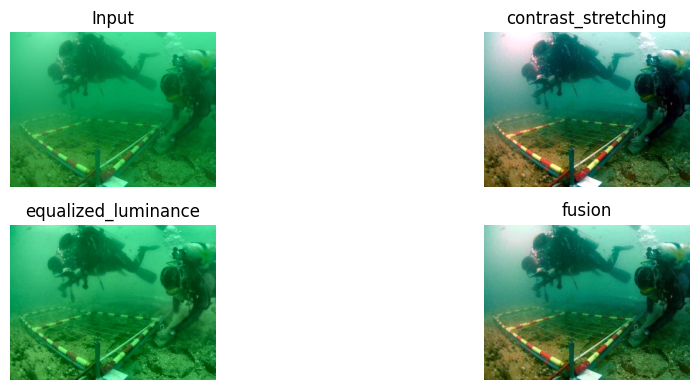

In [11]:
contrast_streching_image = contrast_streching(image)
lab_eq = equalized_luminance(image)
w1, w2 = getFusionWeight(contrast_streching_image, lab_eq)
fusion = multiscale_fusion(contrast_streching_image, lab_eq, w1, w2)

fig, ax = plt.subplots(2, 2, figsize=(12, 4))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));        ax[0,0].set_title('Input'); ax[0,0].axis('off')
ax[0,1].imshow(cv2.cvtColor(contrast_streching_image, cv2.COLOR_BGR2RGB)); ax[0,1].set_title('contrast_stretching'); ax[0,1].axis('off')
ax[1,0].imshow(cv2.cvtColor(lab_eq, cv2.COLOR_BGR2RGB)); ax[1,0].set_title('equalized_luminance'); ax[1,0].axis('off')
ax[1,1].imshow(cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB));        ax[1,1].set_title('fusion'); ax[1,1].axis('off')
plt.tight_layout(); 
plt.show()

# Haar restoration

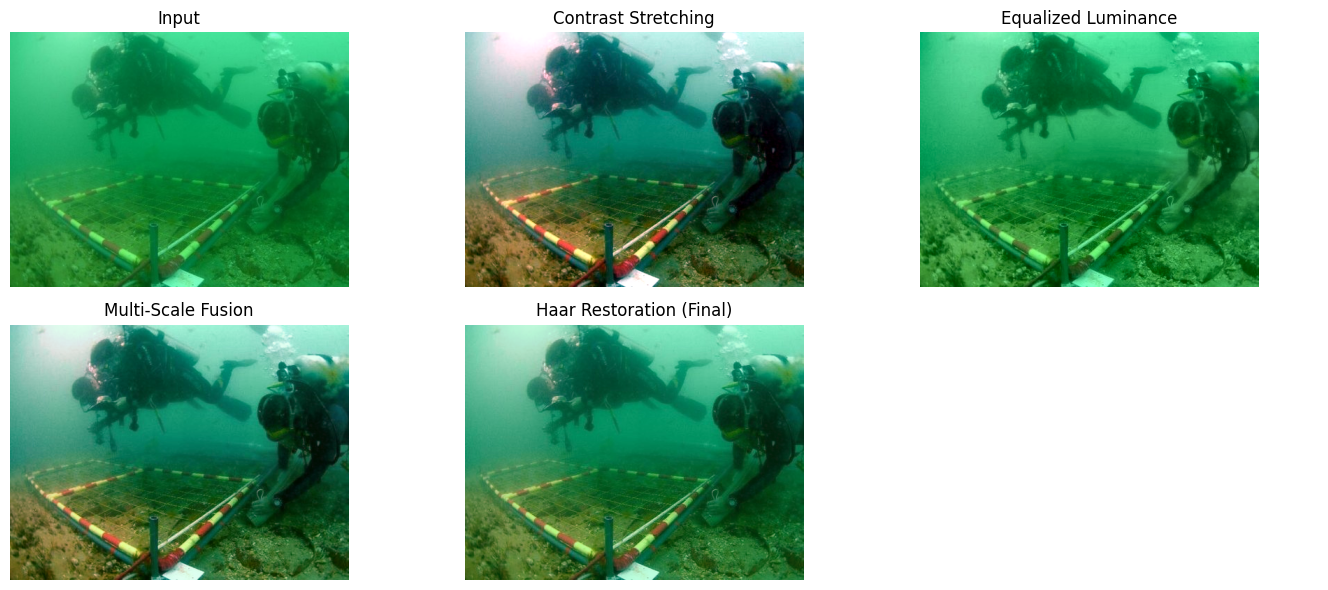

In [12]:
def _pad_to_pow2(img, levels):
    h, w = img.shape[:2]
    m = 2**levels
    nh = (h + m - 1) // m * m
    nw = (w + m - 1) // m * m
    if nh == h and nw == w:
        return img
    return cv2.copyMakeBorder(img, 0, nh-h, 0, nw-w, cv2.BORDER_REFLECT_101)

def haar_dwt2_single(gray, levels=1):
    coeffs = []
    cur = gray.astype(np.float32)
    for _ in range(levels):
        L = (cur[:, 0::2] + cur[:, 1::2]) * 0.5
        H = (cur[:, 0::2] - cur[:, 1::2]) * 0.5
        A = (L[0::2, :] + L[1::2, :]) * 0.5
        V = (L[0::2, :] - L[1::2, :]) * 0.5
        H2 = (H[0::2, :] + H[1::2, :]) * 0.5
        D = (H[0::2, :] - H[1::2, :]) * 0.5
        coeffs.append({'A': A, 'H': H2, 'V': V, 'D': D})
        cur = A
    return coeffs

def haar_idwt2_single(coeffs):
    curA = coeffs[-1]['A']
    for l in range(len(coeffs)-1, -1, -1):
        A, H, V, D = coeffs[l]['A'], coeffs[l]['H'], coeffs[l]['V'], coeffs[l]['D']
        L0 = (A + V)
        L1 = (A - V)
        H0 = (H + D)
        H1 = (H - D)
        upL = np.empty((L0.shape[0]*2, L0.shape[1]), np.float32)
        upH = np.empty_like(upL)
        upL[0::2, :], upL[1::2, :] = L0, L1
        upH[0::2, :], upH[1::2, :] = H0, H1
        out = np.empty((upL.shape[0], upL.shape[1]*2), np.float32)
        out[:, 0::2] = (upL + upH)
        out[:, 1::2] = (upL - upH)
        curA = out
        coeffs[l]['A'] = out
    return curA

def dwt_color(img, levels):
    B, G, R = cv2.split(img.astype(np.float32))
    return [haar_dwt2_single(R, levels),
            haar_dwt2_single(G, levels),
            haar_dwt2_single(B, levels)]

def idwt_color(coeffs_rgb):
    R = haar_idwt2_single(coeffs_rgb[0])
    G = haar_idwt2_single(coeffs_rgb[1])
    B = haar_idwt2_single(coeffs_rgb[2])
    return np.dstack([B, G, R]).astype(np.float32)

def saliency_only_weights_for_haar(ir, ics, levels):
    WS1 = getW_S(ir).astype(np.float32)
    WS2 = getW_S(ics).astype(np.float32)
    denom = WS1 + WS2 + 1e-12
    W1 = WS1 / denom
    W2 = WS2 / denom
    G1 = gaussian_pyr(W1, levels)
    G2 = gaussian_pyr(W2, levels)

    for l in range(levels):
        s = G1[l] + G2[l] + 1e-12
        G1[l] = G1[l] / s
        G2[l] = G2[l] / s
    return G1, G2

def haar_update_with_weights(coeffs_img1, coeffs_img2, Gw1, Gw2):
    levels = len(coeffs_img1[0]) 
    out = []
    eps = 1e-12

    for c in range(3): 
        Ci1, Ci2 = coeffs_img1[c], coeffs_img2[c]
        newc = []
        for l in range(levels):
            Hs, Ws = Ci1[l]['H'].shape
            w1 = cv2.resize(Gw1[l].astype(np.float32), (Ws, Hs), interpolation=cv2.INTER_CUBIC)
            w2 = cv2.resize(Gw2[l].astype(np.float32), (Ws, Hs), interpolation=cv2.INTER_CUBIC)
            s = w1 + w2 + eps
            w1, w2 = w1 / s, w2 / s
            Anew = 0.5 * (Ci1[l]['A'] + Ci2[l]['A'])# (12)
            Hnew = w1 * Ci1[l]['H'] + w2 * Ci2[l]['H']# (9)
            Vnew = w1 * Ci1[l]['V'] + w2 * Ci2[l]['V']# (10)
            Dnew = w1 * Ci1[l]['D'] + w2 * Ci2[l]['D']# (11)

            newc.append({'A': Anew, 'H': Hnew, 'V': Vnew, 'D': Dnew})
        out.append(newc)
    return out


def haar_restoration_after_fusion(image_raw, image_cs, levels=5):

    ir = _pad_to_pow2(image_raw, levels)
    ics = _pad_to_pow2(image_cs, levels)


    coeff_raw = dwt_color(ir, levels)
    coeff_cs  = dwt_color(ics, levels)

    Gw1, Gw2 = saliency_only_weights_for_haar(ir, ics, levels) #use raw & first time streching

    coeff_new = haar_update_with_weights(coeff_raw, coeff_cs, Gw1, Gw2)

    rec = idwt_color(coeff_new)

    h, w = image_raw.shape[:2]
    rec = rec[:h, :w, :]
    return np.clip(rec, 0, 1)

levels = 5
haar_out = haar_restoration_after_fusion(
    image_raw=image,
    image_cs=contrast_streching_image,
    levels=levels
)
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Input'); ax[0,0].axis('off')
ax[0,1].imshow(cv2.cvtColor(contrast_streching_image, cv2.COLOR_BGR2RGB))
ax[0,1].set_title('Contrast Stretching'); ax[0,1].axis('off')
ax[0,2].imshow(cv2.cvtColor(lab_eq, cv2.COLOR_BGR2RGB))
ax[0,2].set_title('Equalized Luminance'); ax[0,2].axis('off')
ax[1,0].imshow(cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB))
ax[1,0].set_title('Multi-Scale Fusion'); ax[1,0].axis('off')
ax[1,1].imshow(cv2.cvtColor(haar_out, cv2.COLOR_BGR2RGB))
ax[1,1].set_title('Haar Restoration (Final)'); ax[1,1].axis('off')
ax[1,2].axis('off')

plt.tight_layout()
plt.show()


# Restoration using different bases

In [13]:
def _conv_rows(img, k):
    return cv2.filter2D(img, -1, k.reshape(1, -1), borderType=cv2.BORDER_REFLECT_101)

def _conv_cols(img, k):
    return cv2.filter2D(img, -1, k.reshape(-1, 1), borderType=cv2.BORDER_REFLECT_101)

def _downsample_cols(img):
    return img[:, ::2].copy()

def _downsample_rows(img):
    return img[::2, :].copy()

def _upsample_cols(img):
    h, w = img.shape
    out = np.zeros((h, w*2), dtype=img.dtype)
    out[:, 0::2] = img
    return out

def _upsample_rows(img):
    h, w = img.shape
    out = np.zeros((h*2, w), dtype=img.dtype)
    out[0::2, :] = img
    return out

def get_wavelet_filters(wname='db4'):
    try:
        import pywt
        w = pywt.Wavelet(wname)
        lo_d = np.asarray(w.dec_lo, dtype=np.float32)
        hi_d = np.asarray(w.dec_hi, dtype=np.float32)
        lo_r = np.asarray(w.rec_lo, dtype=np.float32)
        hi_r = np.asarray(w.rec_hi, dtype=np.float32)
        return lo_d, hi_d, lo_r, hi_r
    except Exception as e:
        raise RuntimeError({e})


def wavelet_dwt2_single(gray, levels, lo_d, hi_d):
    coeffs = []
    cur = gray.astype(np.float32)
    for _ in range(levels):
        Lr = _downsample_cols(_conv_rows(cur, lo_d))
        Hr = _downsample_cols(_conv_rows(cur, hi_d))
        A = _downsample_rows(_conv_cols(Lr, lo_d))
        V = _downsample_rows(_conv_cols(Lr, hi_d))
        H = _downsample_rows(_conv_cols(Hr, lo_d))
        D = _downsample_rows(_conv_cols(Hr, hi_d))
        coeffs.append({'A': A, 'H': H, 'V': V, 'D': D})
        cur = A
    return coeffs


def wavelet_idwt2_single(coeffs, lo_r, hi_r):
    curA = coeffs[-1]['A']
    for l in range(len(coeffs)-1, -1, -1):
        A, H, V, D = coeffs[l]['A'], coeffs[l]['H'], coeffs[l]['V'], coeffs[l]['D']
        Lr_rec = _conv_cols(_upsample_rows(A), lo_r) + _conv_cols(_upsample_rows(V), hi_r)
        Hr_rec = _conv_cols(_upsample_rows(H), lo_r) + _conv_cols(_upsample_rows(D), hi_r)
        out = _conv_rows(_upsample_cols(Lr_rec), lo_r) + _conv_rows(_upsample_cols(Hr_rec), hi_r)
        coeffs[l]['A'] = out
        curA = out
    return curA

def dwt_color_wavelet(img, levels, wname='db4'):
    lo_d, hi_d, lo_r, hi_r = get_wavelet_filters(wname)
    B, G, R = cv2.split(img.astype(np.float32))
    return [
        wavelet_dwt2_single(R, levels, lo_d, hi_d),
        wavelet_dwt2_single(G, levels, lo_d, hi_d),
        wavelet_dwt2_single(B, levels, lo_d, hi_d)
    ]


def idwt_color_wavelet(coeffs_rgb, wname='db4'):
    lo_d, hi_d, lo_r, hi_r = get_wavelet_filters(wname)
    R = wavelet_idwt2_single(coeffs_rgb[0], lo_r, hi_r)
    G = wavelet_idwt2_single(coeffs_rgb[1], lo_r, hi_r)
    B = wavelet_idwt2_single(coeffs_rgb[2], lo_r, hi_r)
    return np.dstack([B, G, R]).astype(np.float32)

def restoration_after_fusion_wavelet(image_raw, image_cs, levels=5, wname='db4'):
    ir  = _pad_to_pow2(image_raw, levels)
    ics = _pad_to_pow2(image_cs, levels)
    coeff_raw = dwt_color_wavelet(ir, levels, wname)
    coeff_cs  = dwt_color_wavelet(ics, levels, wname)
    Gw1, Gw2 = saliency_only_weights_for_haar(ir, ics, levels)
    coeff_new = haar_update_with_weights(coeff_raw, coeff_cs, Gw1, Gw2)
    rec = idwt_color_wavelet(coeff_new, wname)
    h, w = image_raw.shape[:2]
    return np.clip(rec[:h, :w, :], 0, 1)


In [14]:
#fusion_streching_image = contrast_streching(fusion)
haar_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'haar') # Haar
db4_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'db4') # Daubechies 4
sym6_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'sym6') # Symlet 6
bior13_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'bior1.3') # Biorthogonal 1.3
rbio22_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'rbio2.2') # Reverse Biorthogonal 2.2
coif3_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'coif3') # Coiflet 3
dmey_out = restoration_after_fusion_wavelet(image, contrast_streching_image, 5, 'dmey') # Discrete Meyer

# DT-CWT

In [15]:
#!pip install dtcwt

In [16]:
# since DT-CWT is not in PyWavelets, we need to rewrite
try:
    from dtcwt.numpy import Transform2d as _DTX
    from dtcwt.numpy.common import Pyramid as _Pyr
except Exception:
    from dtcwt import Transform2d as _DTX
    from dtcwt.common import Pyramid as _Pyr

def dtcwt2_single(gray, levels=5):
    t = _DTX()
    y = t.forward(gray.astype(np.float32), nlevels=levels)  
    low = y.lowpass.astype(np.float32)
    highs = [hp.astype(np.complex64) for hp in y.highpasses]
    return low, highs

def idtcwt2_single(low, highs):
    t = _DTX()
    pyr = _Pyr(lowpass=low.astype(np.float32),
               highpasses=[hp.astype(np.complex64) for hp in highs])
    rec = t.inverse(pyr)
    return rec.astype(np.float32)

def dwt_color_dtcwt(img, levels=5):
    B, G, R = cv2.split(img.astype(np.float32))
    Lb, Hb = dtcwt2_single(B, levels)
    Lg, Hg = dtcwt2_single(G, levels)
    Lr, Hr = dtcwt2_single(R, levels)
    return [(Lr,Hr), (Lg,Hg), (Lb,Hb)]

def idwt_color_dtcwt(coeffs_rgb):
    (Lr,Hr), (Lg,Hg), (Lb,Hb) = coeffs_rgb
    R = idtcwt2_single(Lr, Hr)
    G = idtcwt2_single(Lg, Hg)
    B = idtcwt2_single(Lb, Hb)
    return np.dstack([B, G, R]).astype(np.float32)

def update_coeffs_dtcwt(coeffs1, coeffs2, Gw1_list, Gw2_list, combine_A='avg'):

    L = len(coeffs1[1]) 
    out_low = None
    out_highs = [None]*L

    cA1, Hs1 = coeffs1
    cA2, Hs2 = coeffs2

    out_low = 0.5*(cA1 + cA2) if combine_A == 'avg' else (cA1 + cA2)

    for lvl in range(L):
        H1 = Hs1[lvl]
        H2 = Hs2[lvl]
        Hh, Hw, Ori = H1.shape
        w1 = cv2.resize(Gw1_list[lvl].astype(np.float32), (Hw, Hh), interpolation=cv2.INTER_CUBIC)
        w2 = cv2.resize(Gw2_list[lvl].astype(np.float32), (Hw, Hh), interpolation=cv2.INTER_CUBIC)
        s = w1 + w2 + 1e-12
        w1, w2 = (w1/s).astype(np.float32), (w2/s).astype(np.float32)
        w1c = w1[..., None]
        w2c = w2[..., None]
        out_highs[lvl] = (w1c*H1 + w2c*H2).astype(np.complex64)

    return (out_low, out_highs)

def dtcwt_restoration_after_fusion(image_raw, image_cs, levels=5, combine_A='avg'):

    ir  = _pad_to_pow2(image_raw, levels)
    ics = _pad_to_pow2(image_cs,  levels)

    coeff_raw = dwt_color_dtcwt(ir,  levels)
    coeff_cs  = dwt_color_dtcwt(ics, levels)

    Gw1, Gw2 = saliency_only_weights_for_haar(ir, ics, levels)

    coeff_new = []
    for c in range(3):
        cn = update_coeffs_dtcwt(coeff_raw[c], coeff_cs[c], Gw1, Gw2, combine_A=combine_A)
        coeff_new.append(cn)

    rec = idwt_color_dtcwt(coeff_new)
    h, w = image_raw.shape[:2]
    rec = rec[:h, :w, :]
    return np.clip(rec, 0, 1).astype(np.float32)

levels = 5

dtcwt_out = dtcwt_restoration_after_fusion(
    image, contrast_streching_image,
    levels=levels, combine_A='avg'   
)

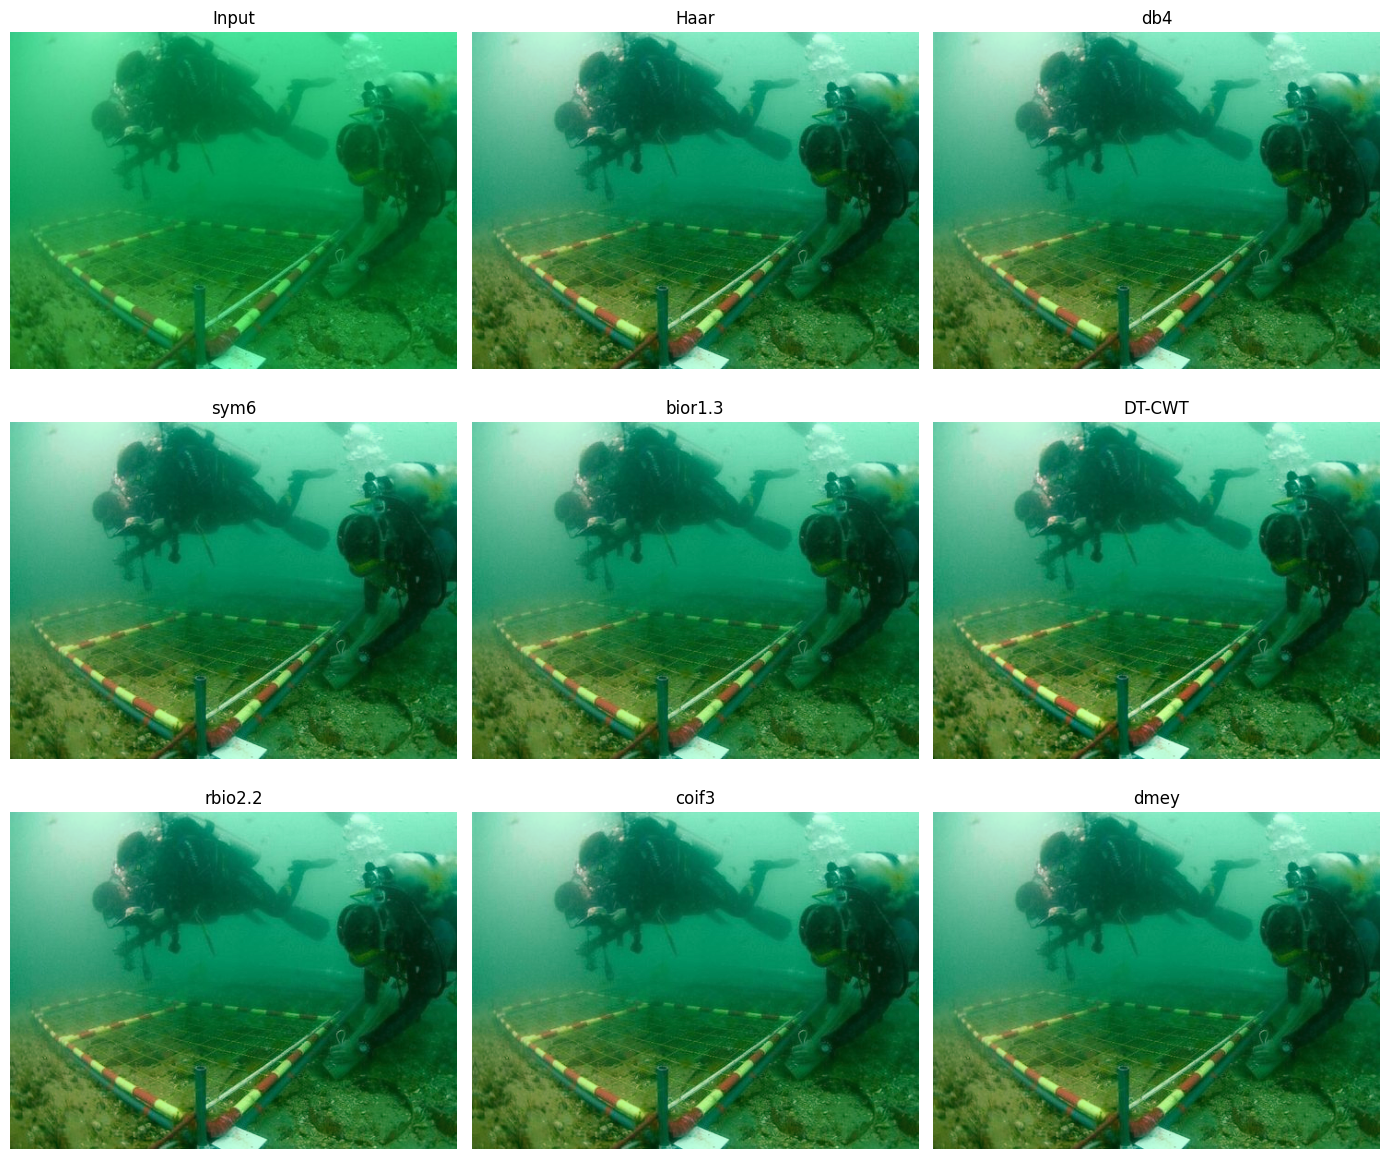

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))

ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Input'); ax[0,0].axis('off')

ax[0,1].imshow(cv2.cvtColor(haar_out, cv2.COLOR_BGR2RGB))
ax[0,1].set_title('Haar'); ax[0,1].axis('off')

ax[0,2].imshow(cv2.cvtColor(db4_out, cv2.COLOR_BGR2RGB))
ax[0,2].set_title('db4'); ax[0,2].axis('off')

ax[1,0].imshow(cv2.cvtColor(sym6_out, cv2.COLOR_BGR2RGB))
ax[1,0].set_title('sym6'); ax[1,0].axis('off')

ax[1,1].imshow(cv2.cvtColor(bior13_out, cv2.COLOR_BGR2RGB))
ax[1,1].set_title('bior1.3'); ax[1,1].axis('off')

ax[1,2].imshow(cv2.cvtColor(dtcwt_out, cv2.COLOR_BGR2RGB))
ax[1,2].set_title('DT-CWT');ax[1,2].axis('off');

ax[2,0].imshow(cv2.cvtColor(rbio22_out, cv2.COLOR_BGR2RGB))
ax[2,0].set_title('rbio2.2'); ax[2,0].axis('off')

ax[2,1].imshow(cv2.cvtColor(coif3_out, cv2.COLOR_BGR2RGB))
ax[2,1].set_title('coif3'); ax[2,1].axis('off')

ax[2,2].imshow(cv2.cvtColor(dmey_out, cv2.COLOR_BGR2RGB))
ax[2,2].set_title('dmey');ax[2,2].axis('off');
plt.tight_layout()
plt.show()

#Looks similar?

In [18]:
# Check decomposition filter length is different and MSE > 0 
import pywt, numpy as np
print('Haar dec_len:',   pywt.Wavelet('haar').dec_len)
print('db4  dec_len:',   pywt.Wavelet('db4').dec_len)
print('sym6 dec_len:',   pywt.Wavelet('sym6').dec_len)
print('bior1.3 dec_len:',pywt.Wavelet('bior1.3').dec_len)
print('rbio2.2 dec_len:',pywt.Wavelet('rbio2.2').dec_len)
print('coif3 dec_len:',  pywt.Wavelet('coif3').dec_len)
print('dmey dec_len:',   pywt.Wavelet('dmey').dec_len)

mse_db4    = np.mean((haar_out - db4_out)**2)
mse_sym6   = np.mean((haar_out - sym6_out)**2)
mse_bior13 = np.mean((haar_out - bior13_out)**2)
mse_rbio22 = np.mean((haar_out - rbio22_out)**2)
mse_coif3  = np.mean((haar_out - coif3_out)**2)
mse_dmey   = np.mean((haar_out - dmey_out)**2)
mse_dtcwt  = np.mean((haar_out - dtcwt_out)**2)

print('\nMSE (vs Haar):')
print(f"db4 = {mse_db4:.6f}")
print(f"sym6 = {mse_sym6:.6f}")
print(f"bior1.3 = {mse_bior13:.6f}")
print(f"rbio2.2 = {mse_rbio22:.6f}")
print(f"coif3 = {mse_coif3:.6f}")
print(f"dmey = {mse_dmey:.6f}")
print(f"DT-CWT = {mse_dtcwt:.6f}")

Haar dec_len: 2
db4  dec_len: 8
sym6 dec_len: 12
bior1.3 dec_len: 6
rbio2.2 dec_len: 6
coif3 dec_len: 18
dmey dec_len: 62

MSE (vs Haar):
db4 = 0.000024
sym6 = 0.000020
bior1.3 = 0.000001
rbio2.2 = 0.000022
coif3 = 0.000033
dmey = 0.000016
DT-CWT = 0.002112


## Evaluation (MSE, PSNR and SSIM)

In [19]:
def compute_mse(img_gt, img_test):
    test = np.clip(img_test * 255.0, 0, 255).astype(np.float32)
    gt = np.clip(img_gt * 255.0, 0, 255).astype(np.float32)

    # Make sure shapes match
    if gt.shape != test.shape:
        raise ValueError(f"Shape mismatch: {gt.shape} vs {test.shape}")

    mse = np.mean((gt - test) ** 2)
    return mse

def compute_psnr(img_gt, img_test):
    # Returns PSNR in dB.
    gt = np.clip(img_gt * 255.0, 0, 255).astype(np.float32)
    test = np.clip(img_test * 255.0, 0, 255).astype(np.float32)

    mse = np.mean((gt - test) ** 2)
    if mse == 0:
        return float('inf')
    max_I = 255.0
    psnr = 10 * np.log10((max_I ** 2) / mse)
    return psnr

def compute_ssim(img_gt, img_test):
    # convert BGR (OpenCV) -> RGB (skimage convention)
    img_gt = np.clip(img_gt * 255.0, 0, 255).astype(np.float32)
    img_test = np.clip(img_test * 255.0, 0, 255).astype(np.float32)
    gt_rgb = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
    test_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    # SSIM expects float images in [0, 1] or uint8 with data_range given
    gt = gt_rgb.astype(np.float32) / 255.0
    test = test_rgb.astype(np.float32) / 255.0

    ssim_val = ssim(gt, test, channel_axis=-1, data_range=1.0)
    return ssim_val

In [20]:
def eme(ch, blocksize=8):
    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    eme_val = 0.0
    w = 2.0 / (num_x * num_y)
    for i in range(num_x):
        xlb = i * blocksize
        xrb = (i+1) * blocksize if i < num_x - 1 else ch.shape[0]

        for j in range(num_y):
            ylb = j * blocksize
            yrb = (j+1) * blocksize if j < num_y - 1 else ch.shape[1]
            
            block = ch[xlb:xrb, ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            if blockmin == 0:
                blockmin += 1
            if blockmax == 0:
                blockmax += 1
            eme_val += w * math.log(blockmax / blockmin)
    return eme_val

def plipsum(i, j, gamma=1026):
    return i + j - i * j / gamma

def plipsub(i, j, k=1026):
    return k * (i - j) / (k - j)

def plipmult(c, j, gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch, blocksize=8):
    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    s = 0.0
    w = 1.0 / (num_x * num_y)
    for i in range(num_x):
        xlb = i * blocksize
        xrb = (i+1) * blocksize if i < num_x - 1 else ch.shape[0]

        for j in range(num_y):
            ylb = j * blocksize
            yrb = (j+1) * blocksize if j < num_y - 1 else ch.shape[1]
            
            block = ch[xlb:xrb, ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            top = plipsub(blockmax, blockmin)
            bottom = plipsum(blockmax, blockmin)

            if bottom == 0:
                continue
            m = top / bottom
            if m != 0.0:
                s += m * np.log(m)

    return plipmult(w, s)

# ---------- UIQM + UCIQE for BGR [0,1] ----------

def compute_uiqm_uciqe_from_bgr01(img_bgr01):
    # Convert to RGB float [0,1] for skimage
    img_rgb01 = cv2.cvtColor(img_bgr01, cv2.COLOR_BGR2RGB)

    # For safety, clip
    img_rgb01 = np.clip(img_rgb01, 0.0, 1.0)

    rgb = img_rgb01
    lab = color.rgb2lab(img_rgb01)    # L ~ [0,100], a,b ~ [-128,128]
    gray = color.rgb2gray(img_rgb01)  # [0,1]

    # ---------- UCIQE ----------
    c1 = 0.4680
    c2 = 0.2745
    c3 = 0.2576
    L = lab[:, :, 0]

    # 1st term: chroma std
    chroma = np.sqrt(lab[:, :, 1]**2 + lab[:, :, 2]**2)
    uc = np.mean(chroma)
    sc = np.sqrt(np.mean((chroma - uc)**2))

    # 2nd term: contrast of L (top 1% high vs low)
    top = int(round(0.01 * L.size))
    sl = np.sort(L, axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[:top]) - np.mean(sl[:top])

    # 3rd term: saturation
    satur = []
    chroma1 = chroma.flatten()
    L1 = L.flatten()
    for i in range(len(L1)):
        if chroma1[i] == 0 or L1[i] == 0:
            satur.append(0.0)
        else:
            satur.append(chroma1[i] / L1[i])
    us = np.mean(satur)

    uciqe = c1 * sc + c2 * conl + c3 * us

    # ---------- UIQM ----------
    p1 = 0.0282
    p2 = 0.2953
    p3 = 3.5753

    # 1st term UICM
    # rgb channels in [0,1]; original weights were tuned for 0–255, but relative ranking is still meaningful
    R = rgb[:, :, 0]
    G = rgb[:, :, 1]
    B = rgb[:, :, 2]

    rg = R - G
    yb = (R + G) / 2 - B

    rgl = np.sort(rg, axis=None)
    ybl = np.sort(yb, axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr)
    s2rg = np.mean((rgl_tr - urg) ** 2)
    uyb = np.mean(ybl_tr)
    s2yb = np.mean((ybl_tr - uyb) ** 2)

    uicm = -0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    # 2nd term UISM
    Rsobel = R * filters.sobel(R)
    Gsobel = G * filters.sobel(G)
    Bsobel = B * filters.sobel(B)

    # Scale to 0–255 for EME function (as in your code)
    Rsobel = np.clip(np.round(Rsobel * 255.0), 0, 255).astype(np.uint8)
    Gsobel = np.clip(np.round(Gsobel * 255.0), 0, 255).astype(np.uint8)
    Bsobel = np.clip(np.round(Bsobel * 255.0), 0, 255).astype(np.uint8)

    Reme = eme(Rsobel)
    Geme = eme(Gsobel)
    Beme = eme(Bsobel)

    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    # 3rd term UIConM
    # gray is [0,1]; scale to 0–255 for logamee if you want to stay close to original implementation
    gray255 = np.clip(gray * 255.0, 0, 255).astype(np.uint8)
    uiconm = logamee(gray255)

    uiqm = p1 * uicm + p2 * uism + p3 * uiconm

    return uiqm, uciqe


In [21]:
def compute_all_metrics(gt_bgr01, out_bgr01):
    # full-reference metrics
    mse_val   = compute_mse(gt_bgr01, out_bgr01)
    psnr_val  = compute_psnr(gt_bgr01, out_bgr01)
    ssim_val  = compute_ssim(gt_bgr01, out_bgr01)

    # no-reference metrics
    uiqm, uciqe = compute_uiqm_uciqe_from_bgr01(out_bgr01)

    print(f"MSE   = {mse_val:.4f}")
    print(f"PSNR  = {psnr_val:.2f} dB")
    print(f"SSIM  = {ssim_val:.4f}")
    print(f"UIQM  = {uiqm:.4f}")
    print(f"UCIQE = {uciqe:.4f}")

    return mse_val, psnr_val, ssim_val, uiqm, uciqe

## Metrics Result

In [22]:
def compute_all_metrics_silent(gt_bgr01, out_bgr01):
    mse   = compute_mse(gt_bgr01, out_bgr01)
    psnr  = compute_psnr(gt_bgr01, out_bgr01)
    ssimv = compute_ssim(gt_bgr01, out_bgr01)
    uiqm, uciqe = compute_uiqm_uciqe_from_bgr01(out_bgr01)
    return mse, psnr, ssimv, uiqm, uciqe

methods_outputs = {
    "Original":   image,
    "Haar":       haar_out,
    "db4":        db4_out,
    "sym6":       sym6_out,
    "bior13":     bior13_out,
    "dtcwt":      dtcwt_out,
    "rbio22":     rbio22_out,
    "coif3":      coif3_out,
    "dmey":       dmey_out
}

rows = []

print("Computing metrics for all wavelet methods...")

for name, out_img in methods_outputs.items():
    if out_img is None:
        print(f"Warning: {name} image is None, skipping.")
        continue
        
    mse, psnr, ssim_val, uiqm, uciqe = compute_all_metrics_silent(gt, out_img)
    
    rows.append({
        "Base": name,
        "MSE": mse,
        "PSNR (dB)": psnr,
        "SSIM": ssim_val,
        "UIQM": uiqm,
        "UCIQE": uciqe,
    })

df_metrics = pd.DataFrame(rows)

pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("\n=== Wavelet Denoising Comparison Table ===")
print(df_metrics)


Computing metrics for all wavelet methods...

=== Wavelet Denoising Comparison Table ===
       Base       MSE  PSNR (dB)   SSIM   UIQM   UCIQE
0  Original 3667.4336    12.4872 0.6837 0.0518 20.1524
1      Haar 1726.2122    15.7599 0.6375 0.1723 26.3391
2       db4 1725.1349    15.7626 0.6376 0.1654 26.3417
3      sym6 1724.4965    15.7642 0.6383 0.1627 26.3275
4    bior13 1725.9105    15.7606 0.6372 0.1687 26.3321
5     dtcwt 1606.1561    16.0729 0.8055 0.2238 26.8079
6    rbio22 1724.9590    15.7630 0.6381 0.1682 26.3323
7     coif3 1724.8879    15.7632 0.6377 0.1638 26.3406
8      dmey 1724.0879    15.7652 0.6382 0.1658 26.3518
